In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import pandas as pd
import healpy as hp
import time
import warnings
%matplotlib inline

In [2]:
warnings.filterwarnings('ignore')

<font size="5">Making a custom power spectrum</font>


<font size="5">Making a full sky map</font>


In [3]:
hmap=hp.read_map("/Users/arefe/Projects/ScatteringTransform/maps/COM_CompMap_Compton-SZMap-milca-ymaps_2048_R2.00.fits")
# hmap=hp.read_map("map1_nside512_seed589_planckbestfit_TT_map.fits")


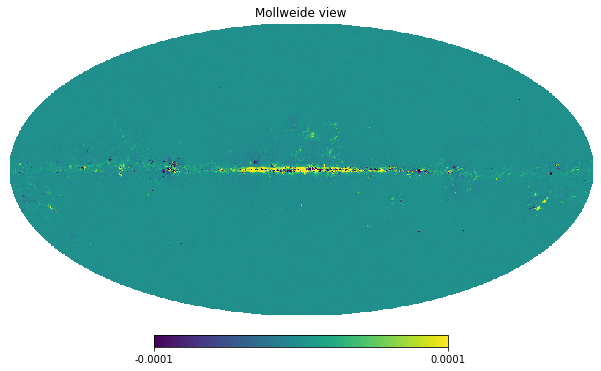

In [4]:
hp.mollview(hmap,min=-0.0001,max=0.0001)

In [5]:
#hmap=hp.ud_grade(hmap,1024)

In [6]:
nside=hp.npix2nside(len(hmap))

Calculating the power spectrum from the map

In [7]:
lmax=3*nside
ell=np.arange(lmax+1)

In [8]:
rcl=hp.anafast(hmap,lmax=lmax,use_pixel_weights=True)

rdl=ell * (ell + 1.) * rcl/(np.pi*2)

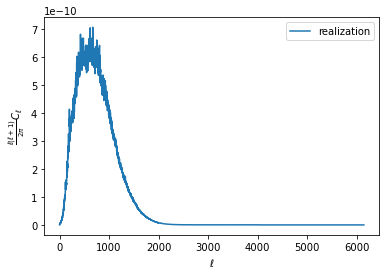

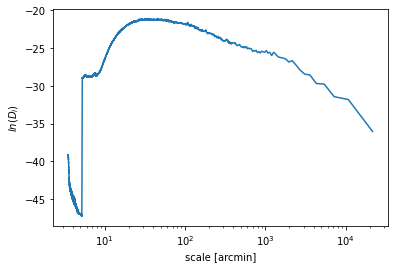

In [9]:
plt.plot(ell,rdl ,label='realization')
# plt.plot(ell,dl,label='theory')
plt.legend()
plt.xlabel("$\ell$")
plt.ylabel(r"$\frac{\ell(\ell+1)}{2\pi}C_{\ell}$")
plt.show()
ellsc=21600/ell
#ellsc=ellsc[::-1]

#fdl=rdl[::-1]
# tfdl=dl[::-1]

#plt.plot(ellsc[:-5],np.log(fdl[:-5]),label='realization')
# plt.plot(ellsc[:-5],np.log(tfdl[:-5]),label='theory')
plt.plot (ellsc,np.log(rdl))
plt.xlabel('scale [arcmin]')
plt.xscale('log')
plt.ylabel('$ln(D_l)$')
plt.show()

resolution of the map

In [10]:
nside=hp.npix2nside(len(hmap))
resarc=hp.nside2resol(nside,arcmin=True)
resol=hp.nside2resol(nside)
print("resolution = %.2f arcmin" % resarc)

resolution = 1.72 arcmin


<font size="5">Defining the Wavelets</font>

These are the radial profile of the wavelet in real space

In [11]:
def gabor(freq,sigma,theta):
    
    arg=-(theta**2)/(2*sigma*sigma) + 1.j * freq*theta
    
    g=np.exp(arg)
    g/=(2*np.pi*sigma*sigma)
    return g

In [12]:
def morlet(f,sigma,theta):
    wv=gabor(f,sigma,theta)
    wvm=gabor(0,sigma, theta)
    B=hp.beam2bl(wv,theta,lmax=lmax)[0]/hp.beam2bl(wvm,theta,lmax=lmax)[0]
#     print(B)
    mor=wv-B*wvm
    return mor

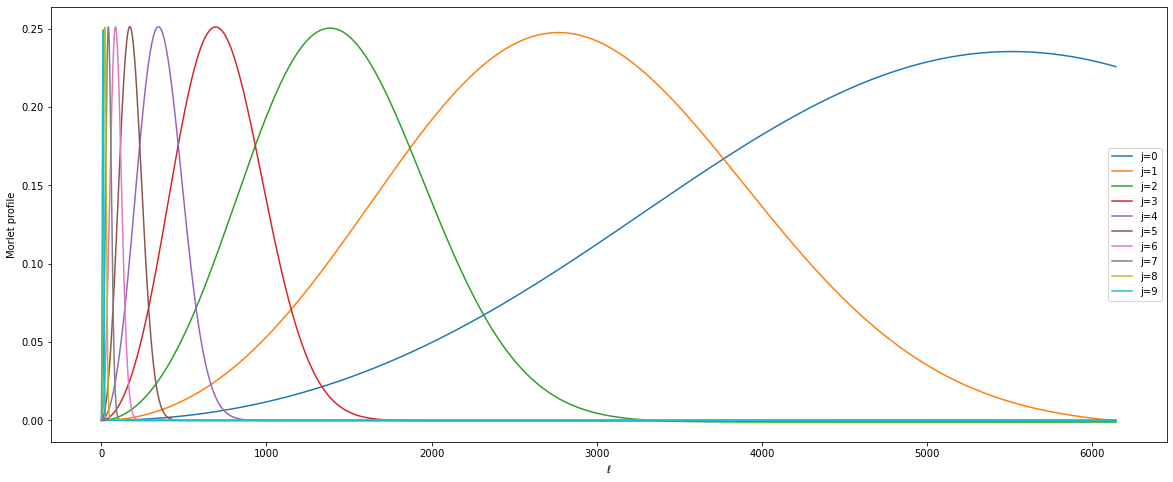

In [15]:
lmax2=lmax
ell2=np.arange(lmax+1)

J=8
morl=[]
fl2beam=[]

theta=np.linspace(0,np.pi,20000)
fig=plt.figure(figsize=[20,8])
for j in range(10):
    sigma1 = (0.8*resol*2**j)
    freq1=(3.0*np.pi) /(4.0*resol*2**j)
    
    morf=morlet(freq1,sigma1,theta)
    mor_l=hp.beam2bl(morf.real,theta,lmax=lmax2)
    
    morl.append(mor_l)

    plt.plot(ell2,mor_l,label='j='+str(j))
#     plt.plot(ell,np.zeros(len(ell)),'k-')
    plt.legend()
plt.xlabel("$\ell$")
plt.ylabel("Morlet profile")
fig.savefig("Morlet_shape.pdf")

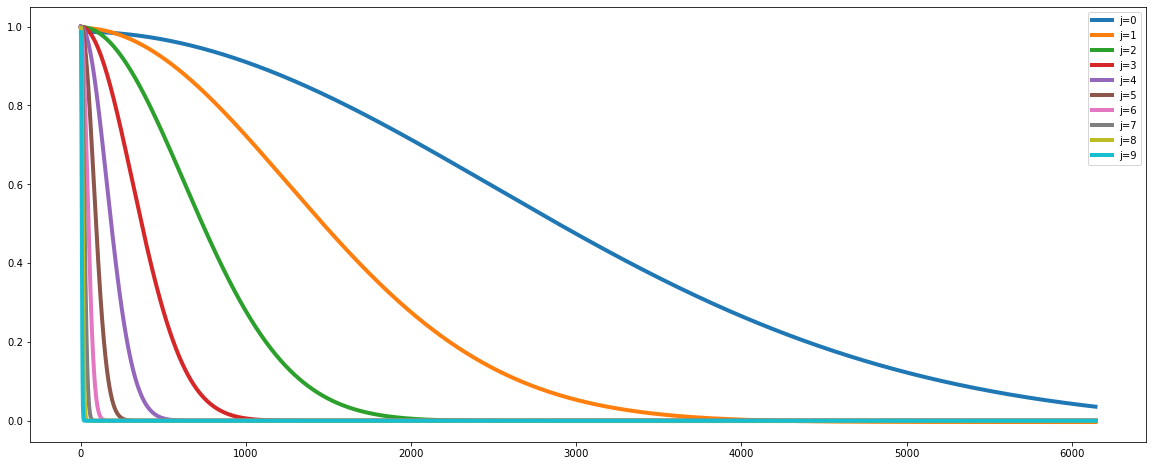

In [27]:
theta=np.linspace(0,np.pi,20000)
fig=plt.figure(figsize=[20,8])

phifilter=[]

for j in range(10):
    sigma1 = (0.8*resol*2**j)
    freq1=(3.0*np.pi) /(4.0*resol*2**j)
    
    phi1=gabor(0,sigma1, theta)
    gab_l=hp.gauss_beam(2*np.sqrt(2*np.log(2))*sigma1,lmax=lmax)
    gab_lb=hp.beam2bl(phi1.real,theta,lmax=lmax)
    
    phifilter.append(gab_l)
    
    plt.plot(ell,gab_lb,label='j='+str(j),lw=4)
    plt.legend()

<font size="5">Scattering Transform</font>

Implementing the transform.

Wavelet description:

$\sigma = 0.8 \times 2^j$

$k = \frac{3\pi}{4 \times 2^j}$

Transform steps

Map = $I_0$

$\psi_1$ = set of filters corresponding to $j_1$

$\psi_2$ = set of filters corresponding to $j_2$

$\phi_1$ = Gaussian filter correspoding to $j_1$

$\phi_2$ = Gaussian filter correspoding to $j_2$

1. $I_1 = |I_0 \star \psi_1|$
2. $S_1 = \langle I_1 \star \phi_1 \rangle$
3. $I_2 = |I_1 \star \psi_2|$
4. $S_2 = \langle I_2 \star \phi_2 \rangle$


In [26]:
lmax

6144

In [26]:
%%time

theta=np.linspace(0,np.pi,5000)

S1=np.zeros((8))

i1=[]
mapalm=hp.map2alm(hmap,lmax=lmax,use_pixel_weights=True)
for j1 in range(8):
    
    sigma1 = (0.8*resol*2**j1) # multiplied by resolution in radians
    freq1=(3.0*np.pi) /(4.0*resol*2**j1) #divided by resolution in radians
    
    #filter 1
    f1=morl[j1] 
    
    #convolving the map with filter 1
    nalm=hp.almxfl(mapalm,f1)
    I1=hp.alm2map(nalm,nside,lmax)
    
    #modulus
    I1=np.abs(I1)
    
    i1.append(I1)
    
    #Gaussian filter for S1
    phif=phifilter[j]
    
    #Convolving with gaussian filter to get S1
    I1alm=hp.map2alm(I1,lmax=lmax,use_pixel_weights=True)
    nI1alm=hp.almxfl(I1alm,phif)
    S1map=hp.alm2map(nI1alm,nside,lmax)
    
    #Averaging the entire map
    S1[j1]=np.mean(S1map)
    print(j1)

0
1
2
3
4
5
6
7
CPU times: user 55min 44s, sys: 18.5 s, total: 56min 2s
Wall time: 15min 39s


In [30]:
nside

2048

In [29]:
np.save("S1_2048_SZ.npy",S1)

No handles with labels found to put in legend.


Text(0.5, 1.0, 'S1 coefficients')

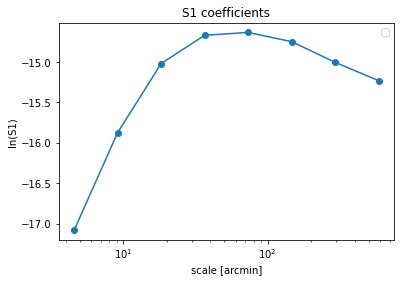

In [31]:
Jf=np.arange(8)
scale=2**Jf*((2*resarc)/0.75)

# plt.plot(scale,np.log(S1m),marker='o',label='map',lw=4)
plt.plot(scale,np.log(S1),marker='o',label='')
plt.legend()
plt.xscale('log')
plt.xlabel("scale [arcmin]")
plt.ylabel("ln(S1)")
plt.title("S1 coefficients")

In [22]:
%%time

S2=np.zeros((8,8))

for j1 in range(8):
    I1=i1[j1]
    
    for j2 in range (8):
                
        sigma2 = (0.8*resol*2**j2)
        freq2=(3.0*np.pi) /(4.0*resol*2**j2)
        
        #filter 2        
        f2=morl[j2]
        
        #Convolving I1 with filter 2
        mapalm2=hp.map2alm(I1,lmax=lmax,use_pixel_weights=True)
        nalm2=hp.almxfl(mapalm2,f2)
        I2=hp.alm2map(nalm2,nside,lmax)
        
        #modulus
        I2=np.abs(I2)
        
        #Gaussian filter to get S2
        phif2=phifilter[j]
    
        #Convolving with gaussian filter to get S2
        I2alm=hp.map2alm(I2,lmax=lmax,use_pixel_weights=True)
        nI2alm=hp.almxfl(I2alm,phif2)
        S2map=hp.alm2map(nI2alm,nside,lmax)     
                       
        #averaging the entire map
        S2[j1][j2]=np.mean(S2map)
    print(j1)

0
1
2
3
4
5
6
7
CPU times: user 1h 36min 58s, sys: 32.1 s, total: 1h 37min 30s
Wall time: 28min 25s


In [23]:
nside

1024

In [24]:
np.save("S2_1024_SZ.npy",S2)

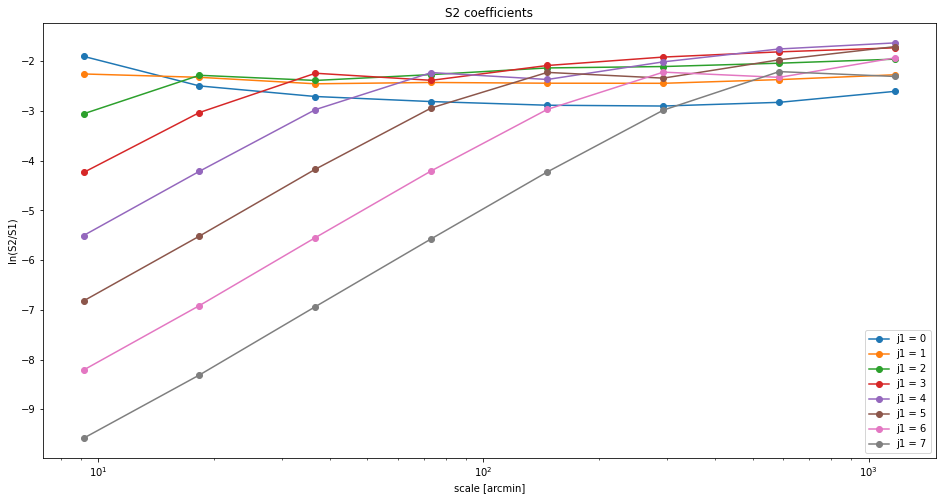

In [25]:
fig=plt.figure(figsize=[16,8])
for j in range (8):
    plt.plot(scale,np.log(S2[j]/S1[j]),marker='o',label="j1 = "+str(j))
    plt.xscale('log')
    plt.xlabel("scale [arcmin]")
    plt.legend(loc='best')
    plt.ylabel("ln(S2/S1)")
    plt.title("S2 coefficients")

Text(0, 0.5, 'ln(s2/s1)')

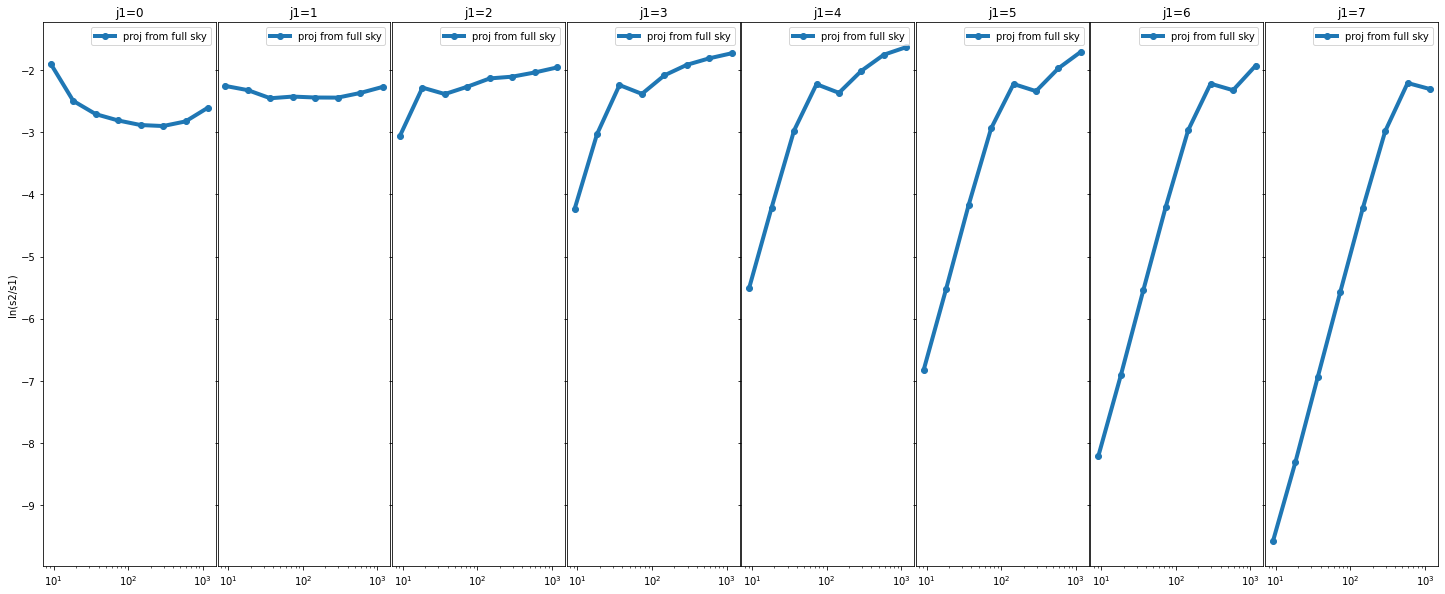

In [26]:
fig, ax = plt.subplots(1, 8,sharey=True,squeeze=True,figsize=(25,10))

ax[0].plot(scale,np.log(S2[0,:]/S1[0]),'o-',label='proj from full sky',lw=4)
# ax[0].plot(scale,np.log(s2[0,:]/cs1[0]),'o-',label='flat sky')
ax[0].set_title('j1=0')
ax[0].set_xscale('log')
ax[0].legend()
ax[1].plot(scale,np.log(S2[1,:]/S1[1]),'o-',label='proj from full sky',lw=4)
# ax[1].plot(scale,np.log(cs2[1,:]/cs1[1]),'o-',label='flat sky')
ax[1].set_title('j1=1')
ax[1].set_xscale('log')
ax[1].legend()
ax[2].plot(scale,np.log(S2[2,:]/S1[2]),'o-',label='proj from full sky',lw=4)
# ax[2].plot(scale,np.log(cs2[2,:]/cs1[2]),'o-',label='flat sky')
ax[2].set_title('j1=2')
ax[2].set_xscale('log')
ax[2].legend()
ax[3].plot(scale,np.log(S2[3,:]/S1[3]),'o-',label='proj from full sky',lw=4)
# ax[3].plot(scale,np.log(cs2[3,:]/cs1[3]),'o-',label='flat sky')
ax[3].set_title('j1=3')
ax[3].set_xscale('log')
ax[3].legend()
ax[4].plot(scale,np.log(S2[4,:]/S1[4]),'o-',label='proj from full sky',lw=4)
# ax[4].plot(scale,np.log(cs2[4,:]/cs1[4]),'o-',label='flat sky')
ax[4].set_title('j1=4')
ax[4].set_xscale('log')
ax[4].legend()
ax[5].plot(scale,np.log(S2[5,:]/S1[5]),'o-',label='proj from full sky',lw=4)
# ax[5].plot(scale,np.log(cs2[5,:]/cs1[5]),'o-',label='flat sky')
ax[5].set_title('j1=5')
ax[5].set_xscale('log')
ax[5].legend()
ax[6].plot(scale,np.log(S2[6,:]/S1[6]),'o-',label='proj from full sky',lw=4)
# ax[6].plot(scale,np.log(cs2[6,:]/cs1[6]),'o-',label='flat sky')
ax[6].set_title('j1=6')
ax[6].set_xscale('log')
ax[6].legend()
ax[7].plot(scale,np.log(S2[7,:]/S1[7]),'o-',label='proj from full sky',lw=4)
# ax[7].plot(scale,np.log(cs2[7,:]/cs1[7]),'o-',label='flat sky')
ax[7].set_title('j1=7')
ax[7].set_xscale('log')
ax[7].legend()
plt.subplots_adjust(wspace=0.01,hspace=0.35)
ax[0].set_ylabel("ln(s2/s1)")

In [28]:
S1


array([0.15967086, 0.17874863, 0.17994386, 0.15203935, 0.10376826,
       0.06890647, 0.0521329 , 0.04254998])

In [29]:
S2

array([[0.01680251, 0.01198892, 0.00696253, 0.0036993 , 0.001934  ,
        0.00311054, 0.00477972, 0.00798728],
       [0.01883149, 0.01810793, 0.01233124, 0.00704599, 0.00373488,
        0.00360367, 0.00535081, 0.00894161],
       [0.01444161, 0.01960398, 0.01742142, 0.01148665, 0.00640811,
        0.00431657, 0.0053918 , 0.0090014 ],
       [0.00800392, 0.01338584, 0.016958  , 0.01372885, 0.00852852,
        0.00505171, 0.00464728, 0.00760552],
       [0.00314758, 0.00577608, 0.00957533, 0.01151317, 0.00888649,
        0.00533287, 0.00359946, 0.00519084],
       [0.00101665, 0.00192383, 0.00366098, 0.00600876, 0.0075785 ,
        0.00612256, 0.00395727, 0.00354921],
       [0.0003704 , 0.00069606, 0.00141326, 0.00252982, 0.0043787 ,
        0.00569969, 0.00467518, 0.00339472],
       [0.00014871, 0.00026723, 0.0005816 , 0.00100817, 0.00197225,
        0.00354302, 0.00438083, 0.0039379 ]])